In [2]:
import tensorflow as tf
import os

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Output will be 1 if GPU is available

Num GPUs Available:  1


In [4]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision

# --- 1. SETTINGS ---
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
mixed_precision.set_global_policy("mixed_float16")

DATA_DIR = r"D:\AI-ENV\Smart Agriculture Plant Disease Detection Using Leaf Images\data\plantvillage dataset\color"
IMG_SIZE = 224 # MobileNetV2 ke liye standard
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# --- 2. DATA PIPELINE (BioScan Style) ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="training", seed=123,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="validation", seed=123,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE
)

class_names = train_ds.class_names

@tf.function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Preprocessing function for MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def prepare_data(ds, augment_data=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare_data(train_ds, augment_data=True)
val_ds = prepare_data(val_ds)

# --- 3. MODEL ARCHITECTURE (Transfer Learning) ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet"
)
base_model.trainable = False # Start with frozen base

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation="softmax", dtype="float32")(x)

model = tf.keras.Model(inputs, outputs)

# --- 4. COMPILE & TRAIN ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n🚀 Starting Training (BioScan Style Optimization)...")
model.fit(train_ds, validation_data=val_ds, epochs=15)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
9406464/9406464 [==============================] - 2s 0us/step

🚀 Starting Training (BioScan Style Optimization)...
Epoch 1/15
679/679 [==============================] - 66s 94ms/step - loss: 0.5453 - accuracy: 0.8560 - val_loss: 0.2328 - val_accuracy: 0.9330
Epoch 2/15
679/679 [==============================] - 62s 91ms/step - loss: 0.2083 - accuracy: 0.9384 - val_loss: 0.1732 - val_accuracy: 0.9491
Epoch 3/15
679/679 [==============================] - 62s 91ms/step - loss: 0.1659 - accuracy: 0.9490 - val_loss: 0.1585 - val_accuracy: 0.9519
Epoch 4/15
679/679 [==============================] - 62s 91ms/step - loss: 0.1403 - accuracy: 0.9559 - val_loss: 0.1393 - val_accuracy: 0.9565
Epoch 5/15
679/679 [==============================] - 61s 90ms/step - loss: 0.1263 - accuracy: 0.9603 - val_loss: 0.1350 - val_accuracy: 0.9576
Epoch 6/15
6

In [12]:
# Base model ko unfreeze karein
base_model.trainable = True

# Sirf last 20 layers ko train hone dein (baaki frozen rahein gi)
# Taake base weights zaya na hon
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Boht low learning rate use karna zaroori hai fine-tuning mein
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 1e-3 se 1e-5 kar diya
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Phase 2: Fine-Tuning Start ---")
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 
)

# Final Save
model.save("plant_disease_model_final_v1.h5")
print("✅ Final Model Saved!")


--- Phase 2: Fine-Tuning Start ---
Epoch 1/10
679/679 [==============================] - 76s 107ms/step - loss: 0.0339 - accuracy: 0.9886 - val_loss: 0.0924 - val_accuracy: 0.9709
Epoch 2/10
679/679 [==============================] - 71s 105ms/step - loss: 0.0277 - accuracy: 0.9912 - val_loss: 0.0849 - val_accuracy: 0.9743
Epoch 3/10
679/679 [==============================] - 71s 104ms/step - loss: 0.0249 - accuracy: 0.9918 - val_loss: 0.0845 - val_accuracy: 0.9747
Epoch 4/10
679/679 [==============================] - 71s 104ms/step - loss: 0.0221 - accuracy: 0.9925 - val_loss: 0.0859 - val_accuracy: 0.9743
Epoch 5/10
679/679 [==============================] - 71s 104ms/step - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.0794 - val_accuracy: 0.9774
Epoch 6/10
679/679 [==============================] - 72s 106ms/step - loss: 0.0176 - accuracy: 0.9943 - val_loss: 0.0763 - val_accuracy: 0.9774
Epoch 7/10
679/679 [==============================] - 71s 104ms/step - loss: 0.0159 - accuracy


🔍 Final Evaluation Start...

--- Final Classification Report ---
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.99      0.97       120
                                 Apple___Black_rot       0.99      0.98      0.99       124
                          Apple___Cedar_apple_rust       1.00      0.98      0.99        56
                                   Apple___healthy       0.99      0.98      0.99       348
                               Blueberry___healthy       0.99      1.00      1.00       318
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       208
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       147
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.72      0.81       109
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       238
             

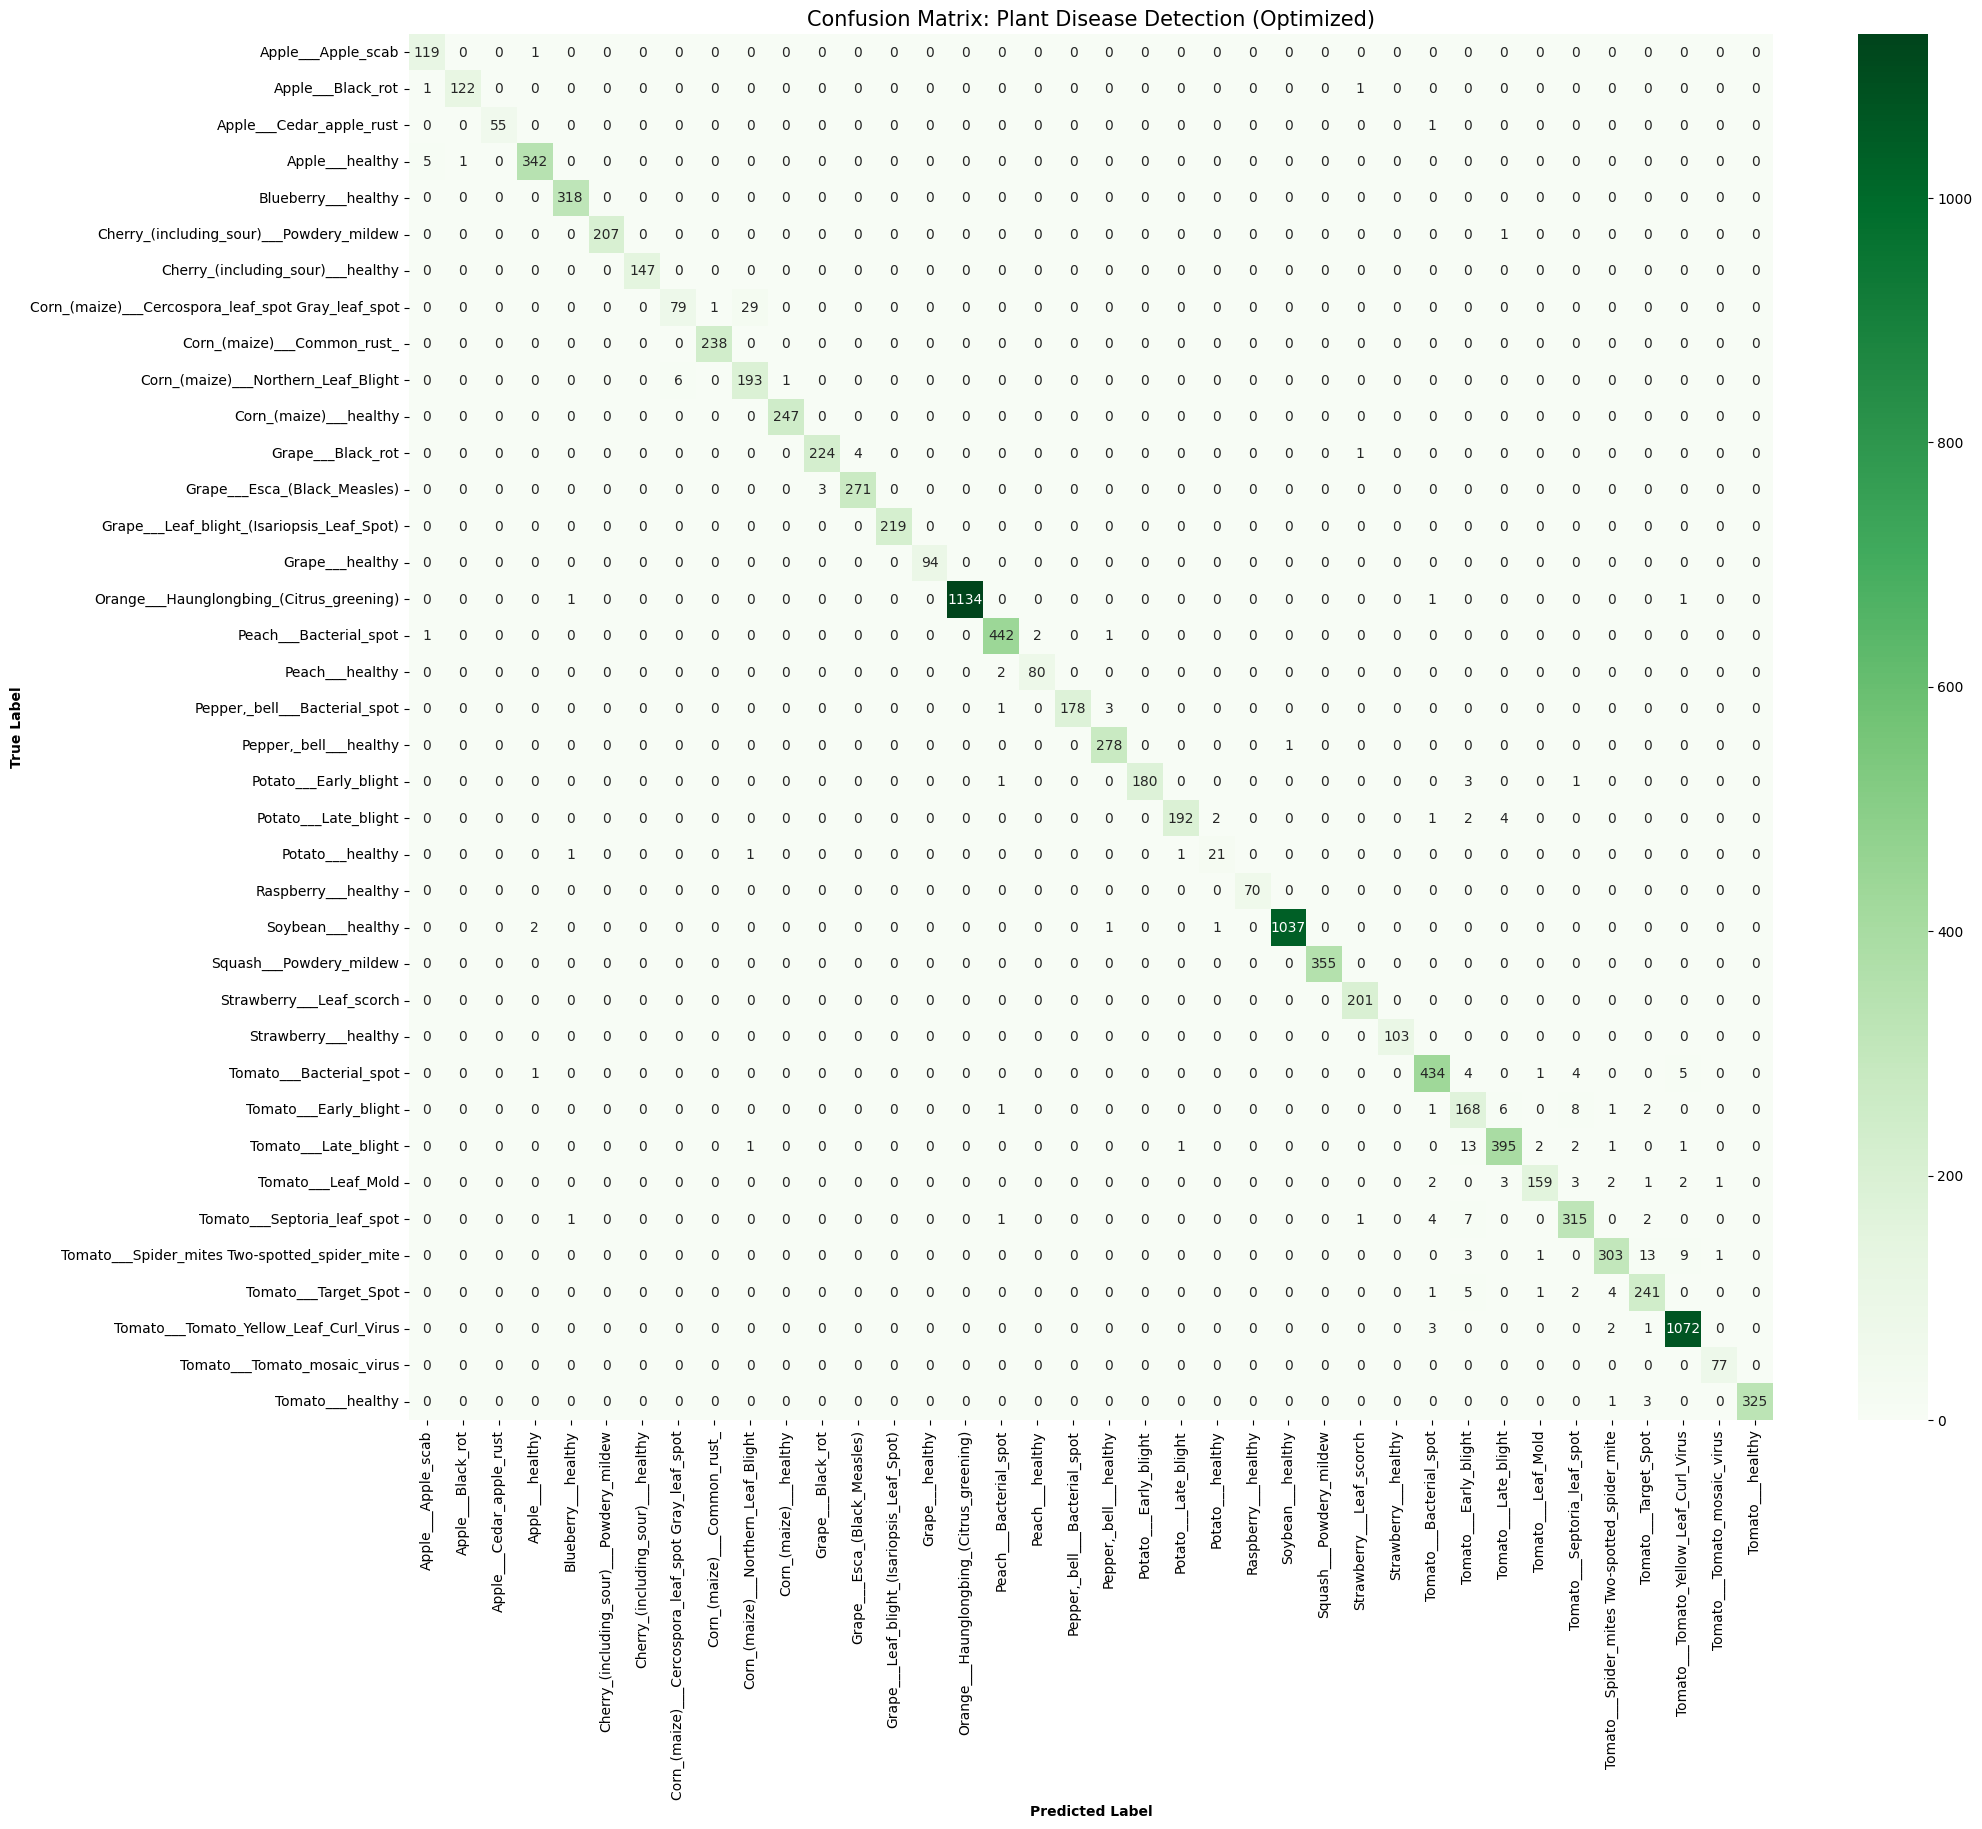

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1. Predictions
y_true = []
y_pred = []

print("\n🔍 Final Evaluation Start...")
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Print Classification Report
print("\n--- Final Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Visual Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(22, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.title('Confusion Matrix: Plant Disease Detection (Optimized)', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [8]:
import os
dataset_path = r"D:\AI-ENV\Smart Agriculture Plant Disease Detection Using Leaf Images\data\plantvillage dataset\color"
names = sorted(os.listdir(dataset_path))
print(names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

1/1 [==============================] - 0s 288ms/step


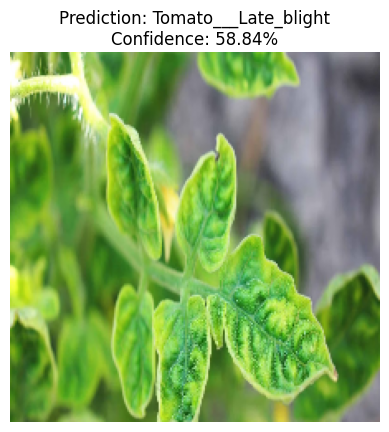

('Tomato___Late_blight', 58.83524417877197)

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def predict_and_plot(image_path, model, class_names):
    # 1. Image Load aur Resize
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    
    # 2. Array mein convert karein
    img_array = tf.keras.utils.img_to_array(img)
    img_dims = np.expand_dims(img_array, axis=0) # Batch dimension add karein

    # 3. ZAROORI: Preprocessing (MobileNetV2 style)
    # Yaad rahe yahan /255.0 nahi karna, sirf ye function use karna hai
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_dims)

    # 4. Prediction
    predictions = model.predict(img_preprocessed)
    score = tf.nn.softmax(predictions[0]) # Scores ko probability mein badlein
    
    predicted_class = class_names[np.argmax(predictions)]
    confidence = 100 * np.max(predictions)

    # 5. Result Visualize karein
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis("off")
    plt.show()

    return predicted_class, confidence

# --- RUN KARNE KA TAREEQA ---
# Pehle model load karein agar memory mein nahi hai
# model = tf.keras.models.load_model('plant_disease_model_final_v1.h5')

image_to_test = r"C:\Users\ABDUL RAFAY\Desktop\tomato yellow leaf curl virus.png" # Kisi bhi image ka path dein
predict_and_plot(image_to_test, model, class_names)

In [11]:
# Notebook mein Top 3 predictions check karne ke liye
import tensorflow as tf
import numpy as np

def check_top_3(image_path, model, class_names):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    preds = model.predict(img_preprocessed)[0]
    
    # Top 3 indices nikalein
    top_indices = preds.argsort()[-3:][::-1]
    
    print("\n--- TOP 3 PREDICTIONS ---")
    for i in top_indices:
        print(f"Class: {class_names[i]} | Confidence: {preds[i]*100:.2f}%")

# Test karein
check_top_3(r"C:\Users\ABDUL RAFAY\Desktop\tomato yellow leaf curl virus.png", model, class_names)

1/1 [==============================] - 0s 32ms/step

--- TOP 3 PREDICTIONS ---
Class: Tomato___Late_blight | Confidence: 58.84%
Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus | Confidence: 39.97%
Class: Tomato___Leaf_Mold | Confidence: 0.53%
